# General Equilibrium

This notebook illustrates **how to solve GE equilibrium models**. The example is a simple one-asset model without nominal rigidities.

The notebook shows how to:

1. Solve for the **stationary equilibrium**.
2. Solve for the (non-linear) **transition path** using a relaxtion algorithm.
3. Solve for **impulse-responses** using the **sequence-space method** of **Auclert et. al. (2020)**.

Details are given in **A Note on Solving Heterogenous Agent General Equilibrium Models.pdf**, which also contains a list of important references.

In [ ]:
LOAD = False # load stationary equilibrium and jacobian
DO_VARY_SIGMA_E = False

# Setup

In [2]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
from scipy import optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from GEModel import GEModelClass

## Choose number of threads in numba

In [3]:
import numba as nb
nb.set_num_threads(8)

# Model

In [4]:
model = GEModelClass('baseline',load=LOAD)
print(model)

Modelclass: GEModelClass
Name: baseline

namespaces: ['par', 'sol', 'sim']
other_attrs: []
savefolder: saved
not_floats: ['Ne', 'Na', 'max_iter_solve', 'max_iter_simulate', 'path_T']

par:
 r_ss = nan [float]
 w_ss = nan [float]
 K_ss = nan [float]
 Y_ss = nan [float]
 C_ss = nan [float]
 kd_ss = nan [float]
 ks_ss = nan [float]
 sigma = 1.0 [float]
 beta = 0.982 [float]
 Z = 1.0 [float]
 alpha = 0.11 [float]
 delta = 0.025 [float]
 rho = 0.966 [float]
 sigma_e = 0.1 [float]
 Ne = 7 [int]
 a_max = 200.0 [float]
 Na = 500 [int]
 path_T = 500 [int]
 max_iter_solve = 5000 [int]
 max_iter_simulate = 5000 [int]
 solve_tol = 1e-10 [float]
 simulate_tol = 1e-10 [float]
 a_grid = ndarray with shape = (500,) [dtype: float64]
 e_grid = ndarray with shape = (7,) [dtype: float64]
 e_trans = ndarray with shape = (7, 7) [dtype: float64]
 e_ergodic = ndarray with shape = (7,) [dtype: float64]
 e_trans_cumsum = ndarray with shape = (7, 7) [dtype: float64]
 e_ergodic_cumsum = ndarray with shape = (7,) 

**Productivity states:**

In [5]:
par = model.par
for e,pr_e in zip(par.e_grid,par.e_ergodic):
    print(f'Pr[e = {e:7.4f}] = {pr_e:.4f}')
    
assert np.isclose(np.sum(par.e_grid*par.e_ergodic),1.0)

Pr[e =  0.3599] = 0.0156
Pr[e =  0.4936] = 0.0938
Pr[e =  0.6769] = 0.2344
Pr[e =  0.9282] = 0.3125
Pr[e =  1.2729] = 0.2344
Pr[e =  1.7456] = 0.0937
Pr[e =  2.3939] = 0.0156


# Find Stationary Equilibrium

**Step 1:** Find demand and supply of capital for a grid of interest rates.

In [6]:
if not LOAD:
    
    par = model.par

    # a. interest rate trial values
    Nr = 50
    r_vec = np.linspace(0.0025,1.0/par.beta-1-0.0025,Nr) # 1+r > beta not possible

    # b. allocate
    Ks = np.zeros(Nr) 
    Kd = np.zeros(Nr)

    # c. loop
    r_min = r_vec[0]
    r_max = r_vec[Nr-1]
    for i_r in range(Nr):

        # i. firm side
        k = model.firm_demand(r_vec[i_r])
        Kd[i_r] = k*1

        # ii. household side
        try:

            # solve and simulate
            model.solve_household_ss(r=r_vec[i_r])
            model.simulate_household_ss()

            # total demand
            Ks[i_r] = np.sum(model.sim.D*model.sol.a)

            # bounds on r
            diff = Ks[i_r]-Kd[i_r]
            if diff < 0: r_min = np.fmax(r_min,r_vec[i_r])
            if diff > 0: r_max = np.fmin(r_max,r_vec[i_r])

        except:

            Ks[i_r] = np.nan  
        

**Step 2:** Plot supply and demand.

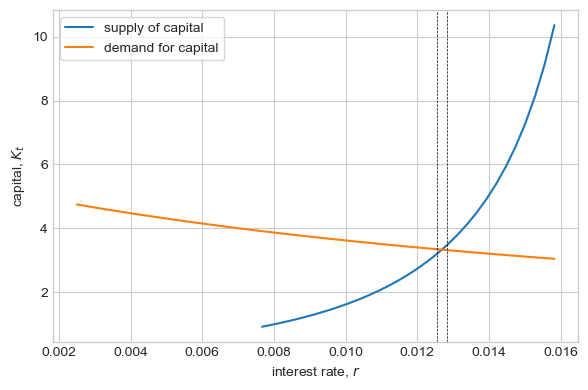

In [7]:
if not LOAD:
    
    par = model.par

    fig = plt.figure(figsize=(6,4),dpi=100)
    ax = fig.add_subplot(1,1,1)

    ax.plot(r_vec,Ks,label='supply of capital')
    ax.plot(r_vec,Kd,label='demand for capital')

    ax.axvline(r_min,lw=0.5,ls='--',color='black')
    ax.axvline(r_max,lw=0.5,ls='--',color='black')

    ax.legend(frameon=True)
    ax.set_xlabel('interest rate, $r$')
    ax.set_ylabel('capital, $K_t$')
    
    fig.tight_layout()
    

**Step 3:** Solve root-finding problem.

In [8]:
def obj(r,model):
    
    model.solve_household_ss(r=r)
    model.simulate_household_ss()
    return np.sum(model.sim.D*model.sol.a)-model.firm_demand(r)

if not LOAD:
    
    sol = optimize.root_scalar(obj,bracket=[r_min,r_max],method='bisect',args=(model,))
    model.par.r_ss = sol.root
    assert sol.converged
    

**Step 4:** Check market clearing conditions.

In [9]:
model.steady_state()

household problem solved in 0.1 secs [652 iterations]
household problem simulated in 0.1 secs [926 iterations]

r: 0.0127
w: 1.0160
Y: 1.1415
K/Y: 2.9186

capital market clearing:   0.00000000
goods market clearing:  -0.00000001


## Income uncertainty and the equilibrium interest rate

The equlibrium interest rate is increased towards $1/\beta-1$ when income uncertainty is lowered.

In [10]:
if DO_VARY_SIGMA_E:
    
    par = model.par

    # a. seetings
    sigma_e_vec = [0.40,0.30,0.20]

    # b. find equilibrium rates
    r_max_ = 1.0/par.beta-1
    model_ = model.copy()
    for sigma_e in sigma_e_vec:

        # i. set new parameter
        model_.par.sigma_e = sigma_e

        # ii. find bracket
        r_max = model_.par.r_ss
        dr = (r_max_-r_max)/10
        while True:
            r_max += dr
            model_.solve_household_ss(r=r_max)
            model_.simulate_household_ss()
            diff = np.sum(model_.sim.D*model_.sol.a)-model_.firm_demand(r=r_max)
            if diff > 0:            
                break

        # iii. solve
        print(f'sigma_e = {sigma_e:.4f} -> r_ss in [{r_max-dr:.4f},{r_max:.4f}]',end='')
        sol = optimize.root_scalar(obj,bracket=[r_max-dr,r_max],method='bisect',args=(model_,))
        print(f' -> r_ss = {sol.root:.4f}')
        model_.steady_state(sol.root)    
        print('\n')
        

# Find transition path

**MIT-shock:** Transtion path for arbitrary exogenous path of $Z_t$ starting from the stationary equilibrium, i.e. $D_{-1} = D_{ss}$ and in particular $K_{-1} = K_{ss}$.

In [11]:
shock = 1.01
persistence = 0.90

**Step 1:** Construct $\{Z_t\}_{t=0}^{T}$.

In [12]:
path_Z = np.ones(par.path_T)
path_Z[0] = shock*par.Z
for t in range(1,par.path_T):
    path_Z[t] = persistence*path_Z[t-1] + (1-persistence)*par.Z

**Step 2:** Apply relaxation algorithm.

In [13]:
# a. allocate
path_r = np.repeat(model.par.r_ss,par.path_T) # use steady state as initial guess
path_r_ = np.empty(par.path_T)
path_K = np.empty(par.path_T)
path_w = np.empty(par.path_T)

# b. setting
nu = 0.90 # relaxation parameter
max_iter = 5000 # maximum number of iterations

# c. iterate
it = 0
path_K[0] = np.sum(model.sim.D*model.sol.a) # capital is pre-determined
while True:
    
    # i. solve and simulate
    model.solve_household_path(path_r) # automatic update of path_w
    model.simulate_household_path()
    
    # ii. implied prices
    for t in range(par.path_T):
        if t < par.path_T-1: path_K[t+1] = np.sum(model.sim.path_D[t]*model.sol.path_a[t])
        path_r_[t] = model.implied_r(path_K[t],path_Z[t])
    
    # iii. difference
    max_abs_diff = np.max(np.abs(path_r-path_r_))
    if it%10 == 0: print(f'{it:4d}: {max_abs_diff:.8f}')
    if max_abs_diff < 1e-8: break
    
    # iv. update
    path_r = nu*path_r + (1-nu)*path_r_
    
    # v.  increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')    
    
# d. find wage    
for t in range(par.path_T):
    path_w[t] = model.implied_w(path_r[t],path_Z[t])

   0: 0.00037690
  10: 0.00013142
  20: 0.00004582
  30: 0.00001598
  40: 0.00000557
  50: 0.00000194
  60: 0.00000068
  70: 0.00000024
  80: 0.00000008
  90: 0.00000003
 100: 0.00000001


**Plot transition-paths:**

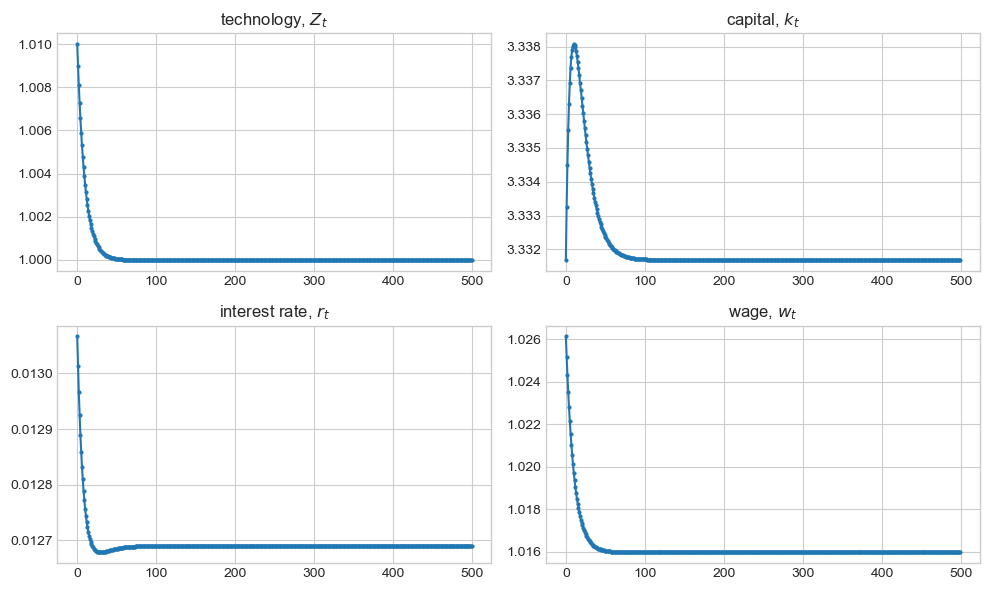

In [14]:
fig = plt.figure(figsize=(10,6),dpi=100)

ax = fig.add_subplot(2,2,1)
ax.plot(np.arange(par.path_T),path_Z,'-o',ms=2)
ax.set_title('technology, $Z_t$');

ax = fig.add_subplot(2,2,2)
ax.plot(np.arange(par.path_T),path_K,'-o',ms=2)
ax.set_title('capital, $k_t$');

ax = fig.add_subplot(2,2,3)
ax.plot(np.arange(par.path_T),path_r,'-o',ms=2)
ax.set_title('interest rate, $r_t$');

ax = fig.add_subplot(2,2,4)
ax.plot(np.arange(par.path_T),path_w,'-o',ms=2)
ax.set_title('wage, $w_t$')

fig.tight_layout()

# Find impulse-responses using sequence-space method

**Paper:** Auclert, A., Bardóczy, B., Rognlie, M., and Straub, L. (2020). *Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models*. **Original code:** [shade-econ](https://github.com/shade-econ/sequence-jacobian/#sequence-space-jacobian)

**This code:** Illustrates the sequence-space method. 

1. The approach taken here is explained in **A Note on Solving Heterogenous Agent General Equilibrium Models.pdf** for an explanation of the method used here.
2. The original paper shows how to do it computationally efficient and for a general class of models.

In [15]:
# unpack previous solution for the stationary equilibrium
par = model.par
sim = model.sim
sol = model.sol

**Step 1:** Compute the Jacobian for the household block around the stationary equilibrium

In [16]:
def jac(price,dprice=1e-4,do_print=True):
    
    jac_K = np.empty((par.path_T,par.path_T))
    jac_C = np.empty((par.path_T,par.path_T))
    for s in range(par.path_T):    
        
        if do_print and t%50 == 0: print(f'{t} ',end='')
        
        # a. baseline path
        path_r = np.repeat(par.r_ss,par.path_T)
        path_w = np.repeat(par.w_ss,par.path_T)
        
        # b. update
        if price == 'r':
            path_r[s] += dprice
        elif price == 'w':
            path_w[s] += dprice
        else:
            raise Exception('unknown price')
            
        # c. solve T periods backwards
        model.solve_household_path(path_r,path_w)

        # the saving functions along the path is
        # sol.path_a[0,:,:], sol.path_a[1,:,:], sol.path_a[2,:,:], ...

        # d. simulate T periods forward starting from the steady 
        model.simulate_household_path(sim.D)

        # the distributions along the  path is
        # sim.path_D[0,:,:], sim.path_D[1,:,:], sim.path_D[2,:,:], ...
        
        jac_K[:,s] = (model.sim.path_K-model.par.K_ss)/dprice
        jac_C[:,s] = (model.sim.path_C-model.par.C_ss)/dprice
    
    return jac_K,jac_C

if not LOAD:
    
    sol.jac_curlyK_r,sol.jac_C_r = jac('r')
    sol.jac_curlyK_w,sol.jac_C_w = jac('w')
    

In [17]:
model.save()

Inspect Jacobians:

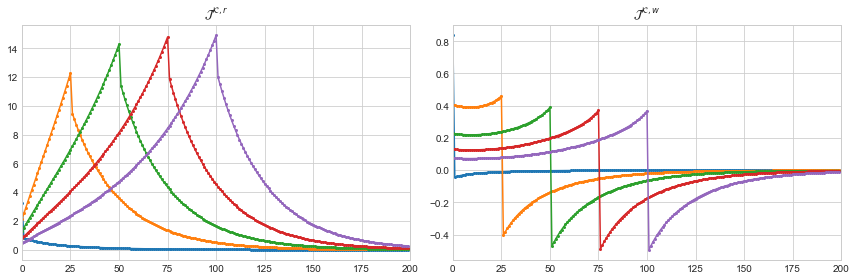

In [18]:
fig = plt.figure(figsize=(12,4))
T_fig = 200

# curlyK_r
ax = fig.add_subplot(1,2,1)
for s in [0,25,50,75,100]:
    ax.plot(np.arange(T_fig),sol.jac_curlyK_r[s,:T_fig],'-o',ms=2)
    
ax.set_title(r'$\mathcal{J}^{\mathcal{K},r}$')
ax.set_xlim([0,T_fig])

# curlyK_w
ax = fig.add_subplot(1,2,2)
for s in [0,25,50,75,100]:
    ax.plot(np.arange(T_fig),sol.jac_curlyK_w[s,:T_fig],'-o',ms=2)
    
ax.set_title(r'$\mathcal{J}^{\mathcal{K},w}$')
ax.set_xlim([0,T_fig])

fig.tight_layout()

**Step 2:** Compute the Jacobians for the firm block around the stationary equilibrium (analytical.

In [19]:
if not LOAD:
    
    sol.jac_r_K[:] = 0
    sol.jac_w_K[:] = 0
    sol.jac_r_Z[:] = 0
    sol.jac_w_Z[:] = 0
    
    for s in range(par.path_T):
        for t in range(par.path_T):
            
            if t == s+1:
                sol.jac_r_K[t,s] = par.alpha*(par.alpha-1)*par.Z*par.K_ss**(par.alpha-2)
                sol.jac_w_K[t,s] = (1-par.alpha)*par.alpha*par.Z*par.K_ss**(par.alpha-1)
            if t == s:
                sol.jac_r_Z[t,s] = par.alpha*par.K_ss**(par.alpha-1)
                sol.jac_w_Z[t,s] = (1-par.alpha)*par.K_ss**par.alpha

**Step 3:** Use the chain rule and solve for $G$.

In [20]:
H_K = sol.jac_curlyK_r @ sol.jac_r_K + sol.jac_curlyK_w @ sol.jac_w_K - np.eye(par.path_T)
H_Z = sol.jac_curlyK_r @ sol.jac_r_Z + sol.jac_curlyK_w @ sol.jac_w_Z 
G_K_Z = -np.linalg.solve(H_K, H_Z) # H_K^(-1)H_Z

**Step 4:** Find effect on prices and other outcomes than $K$.

In [21]:
G_r_Z = sol.jac_r_Z + sol.jac_r_K@G_K_Z
G_w_Z = sol.jac_w_Z + sol.jac_w_K@G_K_Z
G_C_Z = sol.jac_C_r@G_r_Z + sol.jac_C_w@G_w_Z

**Step 5:** Plot impulse-responses.

**Example I:** News shock (i.e. in a single period) vs. persistent shock where $ dZ_t = \rho dZ_{t-1} $ and $dZ_0$ is the initial shock.

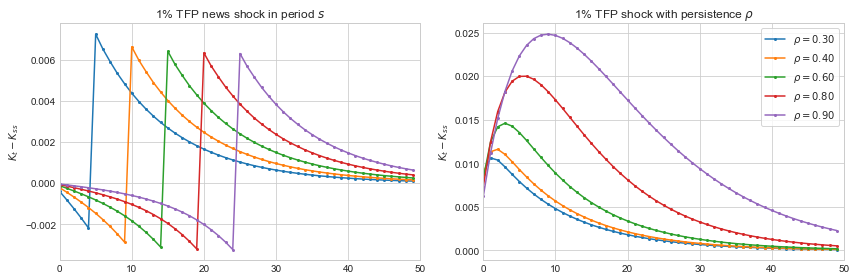

In [22]:
fig = plt.figure(figsize=(12,4))
T_fig = 50

# left: news shock
ax = fig.add_subplot(1,2,1)
for s in [5,10,15,20,25]:
    shock = 0.01
    dZ = shock*par.Z*(np.arange(par.path_T) == s)
    dK = G_K_Z@dZ    
    ax.plot(np.arange(T_fig),dK[:T_fig],'-o',ms=2)
    
ax.set_title(r'1% TFP news shock in period $s$')
ax.set_ylabel('$K_t-K_{ss}$')
ax.set_xlim([0,T_fig])

# right: persistent shock
ax = fig.add_subplot(1,2,2)
for rho in np.array([0.3,0.4,0.6,0.8,0.9]):
    shock = 0.01
    dZ = shock*par.Z*rho**np.arange(par.path_T)
    dK = G_K_Z@dZ
    ax.plot(np.arange(T_fig),dK[:T_fig],'-o',ms=2,label=f'$\\rho = {rho:.2f}$')
        
ax.legend(frameon=True)
ax.set_title(r'1% TFP shock with persistence $\rho$')
ax.set_ylabel('$K_t-K_{ss}$')
ax.set_xlim([0,T_fig])

fig.tight_layout()

**Example II:** Further effects of persistent shock.

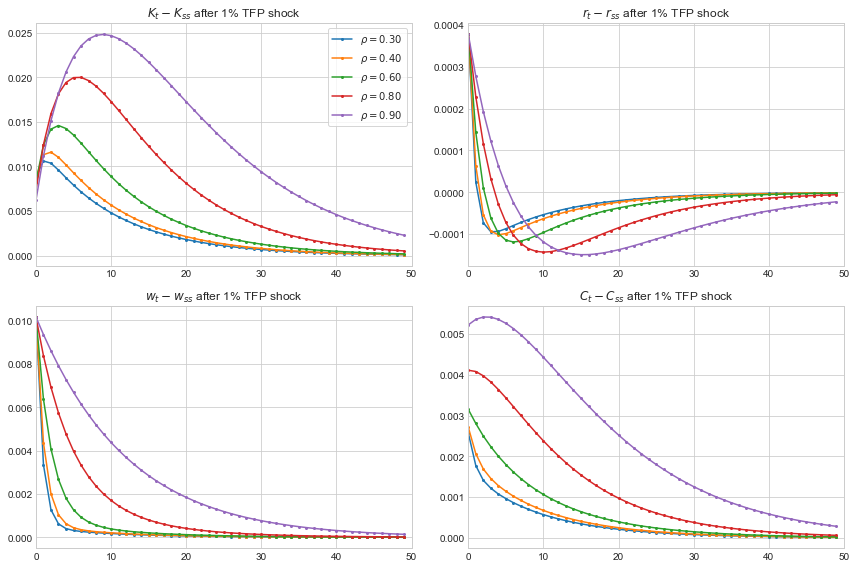

In [23]:
fig = plt.figure(figsize=(12,8))
T_fig = 50

ax_K = fig.add_subplot(2,2,1)
ax_r = fig.add_subplot(2,2,2)
ax_w = fig.add_subplot(2,2,3)
ax_C = fig.add_subplot(2,2,4)

ax_K.set_title('$K_t-K_{ss}$ after 1% TFP shock')
ax_K.set_xlim([0,T_fig])
  
ax_r.set_title('$r_t-r_{ss}$ after 1% TFP shock')
ax_r.set_xlim([0,T_fig])

ax_w.set_title('$w_t-w_{ss}$ after 1% TFP shock')
ax_w.set_xlim([0,T_fig])

ax_C.set_title('$C_t-C_{ss}$ after 1% TFP shock')
ax_C.set_xlim([0,T_fig])

for rho in np.array([0.3,0.4,0.6,0.8,0.9]):
    
    dZ = 0.01*par.Z*rho**np.arange(par.path_T)
    
    dK = G_K_Z@dZ
    ax_K.plot(np.arange(T_fig),dK[:T_fig],'-o',ms=2,label=f'$\\rho = {rho:.2f}$')
        
    dr = G_r_Z@dZ 
    ax_r.plot(np.arange(T_fig),dr[:T_fig],'-o',ms=2)

    dw = G_w_Z@dZ 
    ax_w.plot(np.arange(T_fig),dw[:T_fig],'-o',ms=2)
    
    dC = G_C_Z@dZ
    ax_C.plot(np.arange(T_fig),dC[:T_fig],'-o',ms=2)
    
ax_K.legend(frameon=True)    
fig.tight_layout()

## Covariances

Assume that $Z_t$ is stochastic and follows

$$ d\tilde{Z}_t = \rho d\tilde{Z}_{t-1} + \sigma\epsilon_t,\,\,\, \epsilon_t \sim \mathcal{N}(0,1) $$

The covariances between all outcomes can be calculated as follows.

In [24]:
# a. choose parameter
rho = 0.90
sigma = 0.10

# b. find change in outputs
dZ = rho**(np.arange(par.path_T))
dC = G_C_Z@dZ
dK = G_K_Z@dZ

# c. covariance of consumption
print('auto-covariance of consumption:\n')
for k in range(5):
    if k == 0:
        autocov_C = sigma**2*np.sum(dC*dC)
    else:
        autocov_C = sigma**2*np.sum(dC[:-k]*dC[k:])
    print(f' k = {k}: {autocov_C:.4f}')
    
# d. covariance of consumption and capital
cov_C_K = sigma**2*np.sum(dC*dK)
print(f'\ncovariance of consumption and capital: {cov_C_K:.4f}')

auto-covariance of consumption:

 k = 0: 0.0443
 k = 1: 0.0429
 k = 2: 0.0414
 k = 3: 0.0397
 k = 4: 0.0380

covariance of consumption and capital: 0.2109


## Non-linear transition path

Use the Jacobian to speed-up solving for the non-linear transition path using a quasi-Newton method.

In [25]:
# not done yet

# Extra: No idiosyncratic uncertainty

This section solve for the transition path in the case without idiosyncratic uncertainty.

**Analytical solution for steady state:**

In [26]:
r_ss_pf = (1/par.beta-1) # from euler-equation
w_ss_pf = model.implied_w(r_ss_pf)
K_ss_pf = model.firm_demand(r_ss_pf)
Y_ss_pf = model.firm_production(K_ss_pf)
C_ss_pf = Y_ss_pf-par.delta*K_ss_pf

print(f'r: {r_ss_pf:.6f}')
print(f'w: {w_ss_pf:.6f}')
print(f'Y: {Y_ss_pf:.6f}')
print(f'C: {C_ss_pf:.6f}')
print(f'K/Y: {K_ss_pf/Y_ss_pf:.6f}')

r: 0.018330
w: 0.998613
Y: 1.122037
C: 1.050826
K/Y: 2.538660


**Function for finding consumption and capital paths given paths of interest rates and wages:**

It can be shown that

$$ C_{0}=\frac{(1+r_{0})a_{-1}+\sum_{t=0}^{\infty}\frac{1}{\mathcal{R}_{t}}w_{t}}{\sum_{t=0}^{\infty}\beta^{t/\rho}\mathcal{R}_{t}^{\frac{1-\rho}{\rho}}} $$

where 

$$ \mathcal{R}_{t} =\begin{cases} 1 & \text{if }t=0\\ (1+r_{t})\mathcal{R}_{t-1} & \text{else} \end{cases} $$

Otherwise the **Euler-equation** holds

$$ C_t = (\beta (1+r_{t}))^{\frac{1}{\sigma}}C_{t-1} $$

In [27]:
def path_CK_func(K0,path_r,path_w,r_ss,w_ss,model):
    
    par = model.par
    
    # a. initialize
    wealth = (1+path_r[0])*K0
    inv_MPC = 0
    
    # b. solve
    RT = 1
    max_iter = 5000
    t = 0
    while True and t < max_iter: 
        
        # i. prices padded with steady state
        r = path_r[t] if t < par.path_T else r_ss
        w = path_w[t] if t < par.path_T else w_ss
        
        # ii. interest rate factor 
        if t == 0:
            fac = 1
        else:
            fac *= (1+r)
        
        # iii. accumulate
        add_wealth = w/fac
        add_inv_MPC = par.beta**(t/par.sigma)*fac**((1-par.sigma)/par.sigma)
        if np.fmax(add_wealth,add_inv_MPC) < 1e-12:
            break
        else:
            wealth += add_wealth
            inv_MPC += add_inv_MPC
        
        # iv. increment
        t += 1
        
    # b. simulate
    path_C = np.empty(par.path_T)
    path_K = np.empty(par.path_T)
    
    for t in range(par.path_T):
        
        if t == 0:
            path_C[t] = wealth/inv_MPC
            K_lag = K0
        else:
            path_C[t] = (par.beta*(1+path_r[t]))**(1/par.sigma)*path_C[t-1]
            K_lag = path_K[t-1]
        
        path_K[t] = (1+path_r[t])*K_lag + path_w[t] - path_C[t]
            
    return path_K,path_C

**Test with steady state prices:**

In [28]:
path_r_pf = np.repeat(r_ss_pf,par.path_T)
path_w_pf = np.repeat(w_ss_pf,par.path_T)
path_K_pf,path_C_pf = path_CK_func(K_ss_pf,path_r_pf,path_w_pf,r_ss_pf,w_ss_pf,model)

In [29]:
print(f'C_ss:  {C_ss_pf:.6f}')
print(f'C[0]:  {path_C_pf[0]:.6f}')
print(f'C[-1]: {path_C_pf[-1]:.6f}')
assert np.isclose(C_ss_pf,path_C_pf[0])

C_ss:  1.050826
C[0]:  1.050826
C[-1]: 1.050826


**Shock paths** where interest rate deviate in one period:

In [30]:
dr = 1e-4
ts = np.array([0,20,40])
path_C_pf_shock = np.empty((ts.size,par.path_T))
path_K_pf_shock = np.empty((ts.size,par.path_T))

for i,t in enumerate(ts):
    
    path_r_pf_shock = path_r_pf.copy()
    path_r_pf_shock[t] += dr
    
    K,C = path_CK_func(K_ss_pf,path_r_pf_shock,path_w_pf,r_ss_pf,w_ss_pf,model)
    
    path_K_pf_shock[i,:] = K
    path_C_pf_shock[i,:] = C

**Plot paths:**

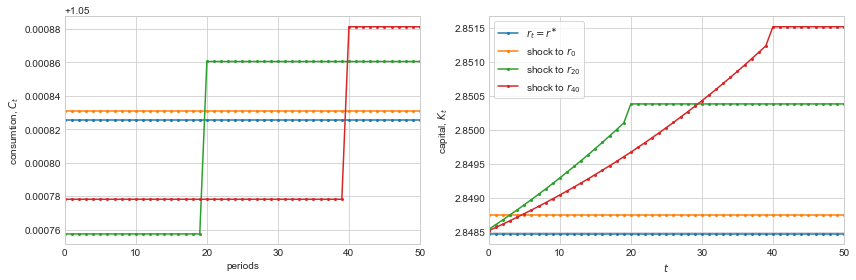

In [31]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
ax.plot(np.arange(par.path_T),path_C_pf,'-o',ms=2,label=f'$r_t = r^{{\\ast}}$')
for i,t in enumerate(ts):
    ax.plot(np.arange(par.path_T),path_C_pf_shock[i],'-o',ms=2,label=f'shock to $r_{{{t}}}$')
    
ax.set_xlim([0,50])
ax.set_xlabel('periods')
ax.set_ylabel('consumtion, $C_t$');

ax = fig.add_subplot(1,2,2)
ax.plot(np.arange(par.path_T),path_K_pf,'-o',ms=2,label=f'$r_t = r^{{\\ast}}$')
for i,t in enumerate(ts):
    ax.plot(np.arange(par.path_T),path_K_pf_shock[i],'-o',ms=2,label=f'shock to $r_{{{t}}}$')
    
ax.legend(frameon=True)
ax.set_xlim([0,50])
ax.set_xlabel('$t$')
ax.set_ylabel('capital, $K_t$');

fig.tight_layout()

**Find transition path with shooting algorithm:**

In [32]:
# a. allocate
dT = 200
path_C_pf = np.empty(par.path_T)
path_K_pf = np.empty(par.path_T)
path_r_pf = np.empty(par.path_T)
path_w_pf = np.empty(par.path_T)

# b. settings
C_min = C_ss_pf
C_max = C_ss_pf + K_ss_pf

K_min = 1.5 # guess on lower consumption if below this
K_max = 3 # guess on higher consumption if above this

tol_pf = 1e-6
max_iter_pf = 5000

path_K_pf[0] = K_ss_pf # capital is pre-determined

# c. iterate
t = 0
it = 0
while True:

    # i. update prices
    path_r_pf[t] = model.implied_r(path_K_pf[t],path_Z[t])
    path_w_pf[t] = model.implied_w(path_r_pf[t],path_Z[t])
    
    # ii. consumption     
    if t == 0:
        C0 = (C_min+C_max)/2
        path_C_pf[t] = C0
    else:
        path_C_pf[t] = (1+path_r_pf[t])*par.beta*path_C_pf[t-1]
    
    # iii. check for steady state
    if path_K_pf[t] < K_min:
        t = 0
        C_max = C0
        continue
    elif path_K_pf[t] > K_max:
        t = 0
        C_min = C0
        continue
    elif t > 10 and np.sqrt((path_C_pf[t]-C_ss_pf)**2+(path_K_pf[t]-K_ss_pf)**2) < tol_pf:
        path_C_pf[t:] = path_C_pf[t]
        path_K_pf[t:] = path_K_pf[t]
        for k in range(par.path_T):
            path_r_pf[k] = model.implied_r(path_K_pf[k],path_Z[k])
            path_w_pf[k] = model.implied_w(path_r_pf[k],path_Z[k])
        break
        
    # iv. update capital
    path_K_pf[t+1] = (1+path_r_pf[t])*path_K_pf[t] + path_w_pf[t] - path_C_pf[t]    
    
    # v. increment
    t += 1
    it += 1
    if it > max_iter: break    

**Plot deviations from steady state:**

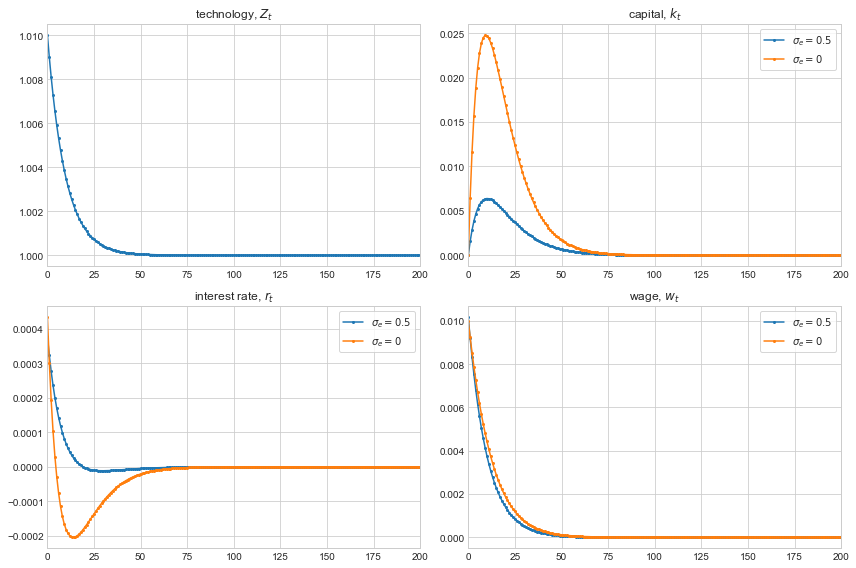

In [33]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(2,2,1)
ax.plot(np.arange(par.path_T),path_Z,'-o',ms=2)
ax.set_xlim([0,200])
ax.set_title('technology, $Z_t$')

ax = fig.add_subplot(2,2,2)
ax.plot(np.arange(par.path_T),path_K-model.par.kd_ss,'-o',ms=2,label='$\sigma_e = 0.5$')
ax.plot(np.arange(par.path_T),path_K_pf-K_ss_pf,'-o',ms=2,label='$\sigma_e = 0$')
ax.legend(frameon=True)
ax.set_title('capital, $k_t$')
ax.set_xlim([0,200])

ax = fig.add_subplot(2,2,3)
ax.plot(np.arange(par.path_T),path_r-model.par.r_ss,'-o',ms=2,label='$\sigma_e = 0.5$')
ax.plot(np.arange(par.path_T),path_r_pf-r_ss_pf,'-o',ms=2,label='$\sigma_e = 0$')
ax.legend(frameon=True)
ax.set_title('interest rate, $r_t$')
ax.set_xlim([0,200])

ax = fig.add_subplot(2,2,4)
ax.plot(np.arange(par.path_T),path_w-model.par.w_ss,'-o',ms=2,label='$\sigma_e = 0.5$')
ax.plot(np.arange(par.path_T),path_w_pf-w_ss_pf,'-o',ms=2,label='$\sigma_e = 0$')
ax.legend(frameon=True)
ax.set_title('wage, $w_t$')
ax.set_xlim([0,200])

fig.tight_layout()